In [106]:
# Imports

import torch
import torch.utils.data
import torchvision
import typing
import random
import PIL.Image
import PIL.ImageDraw
import matplotlib.pyplot

In [107]:
# Constants

IMAGE_DIRECTORY_PATH = "archive/license_plates_detection_train/"
IMAGE_ANNOTATIONS_CSV_PATH = "archive/license_plates_detection_train.csv"
TRAIN_VALIDATION_SPLIT_RATIO = 0.8
TRAIN_BATCH_SIZE = 1
TRAIN_RANDOM_SEED = 0
IMAGE_TRANSFORM_SIZE = (200, 200)

In [108]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data : typing.Sequence[typing.Tuple[object, object]], input_transforms = None, target_transforms=None):
        self.input_transforms = input_transforms
        self.target_transforms = target_transforms
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        input, target = self.data[index]

        if self.input_transforms is not None:
            input = self.input_transforms(input)

        if self.target_transforms is not None:
            target = self.target_transforms(target)

        return input, target

In [109]:
def load_csv(path):
    with open(path, "r") as file:
        # split by row and comma
        lines = list(map(lambda x : x.split(","), file.read().splitlines()))
        # zip column names together with values
        csv_entries = list(map(lambda x : dict(zip(lines[0], x)), lines[1:]))
        # convert all string digits to int type
        csv_entries = list(map(lambda x : { k:int(v) if v.isdigit() else v for k,v in x.items()}, csv_entries))
        return csv_entries

In [110]:
def load_dataset():
    csv_entries = load_csv(IMAGE_ANNOTATIONS_CSV_PATH)[:50]

    def to_dataset_entry(csv_entry):
        image = PIL.Image.open(f"{IMAGE_DIRECTORY_PATH}{csv_entry['img_id']}")
        target = (
            csv_entry['xmin'] / image.size[0],
            csv_entry['ymin'] / image.size[1],
            csv_entry['xmax'] / image.size[0],
            csv_entry['ymax'] / image.size[1],
        )
        return (image, target)
    
    return Dataset(list(map(to_dataset_entry, csv_entries)))

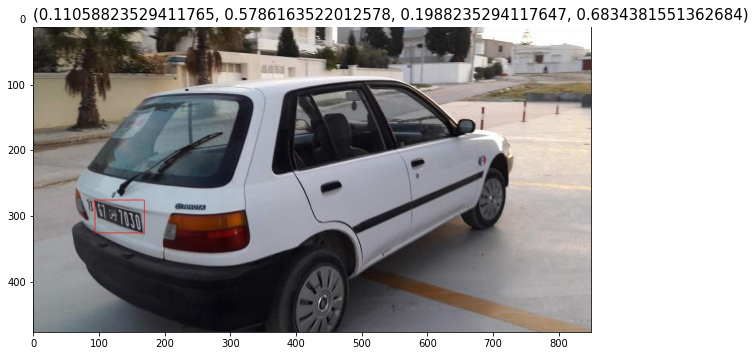

In [111]:
def print_dataset_entry(entry):
    input, target = entry
    
    if isinstance(input, torch.Tensor):
        input = torchvision.transforms.transforms.F.to_pil_image(input)

    # draw license plate
    draw = PIL.ImageDraw.Draw(input)
    draw.rectangle((
            target[0] * input.size[0], 
            target[1] * input.size[1], 
            target[2] * input.size[0], 
            target[3] * input.size[1]
        ), 
        fill=None, outline='red')

    matplotlib.pyplot.figure(figsize=(10, 10))
    matplotlib.pyplot.text(0, 0, str(target), fontsize=15, backgroundcolor='white')
    matplotlib.pyplot.imshow(input)

print_dataset_entry(load_dataset()[0])

In [112]:
def load_transformed_dataset():
    dataset = load_dataset()

    class InputTransform:
        def __init__(self):
            pass

        def __call__(self, input):
            input = input.resize(IMAGE_TRANSFORM_SIZE)
            #input = torchvision.transforms.transforms.F.to_grayscale(input, num_output_channels=3)
            input = torchvision.transforms.transforms.F.to_tensor(input)
            return input

    dataset.input_transforms = InputTransform()

    class TargetTransform:
        def __init__(self):
            pass

        def __call__(self, target):
            target = torch.Tensor(target)
            return target

    dataset.target_transforms = TargetTransform()
    
    return dataset

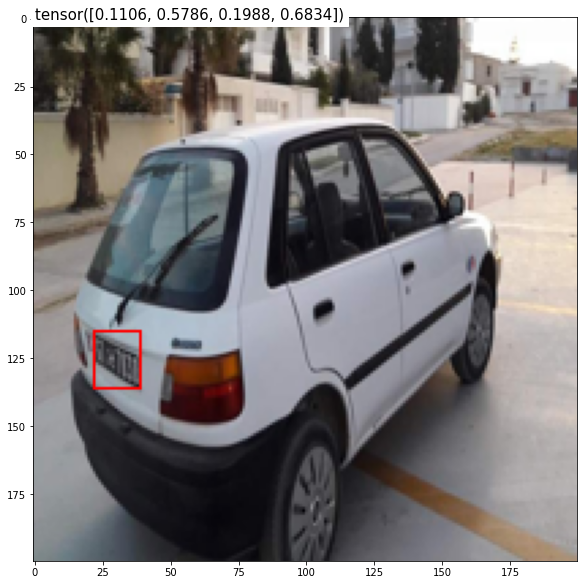

In [113]:
print_dataset_entry(load_transformed_dataset()[0])

In [114]:
class Model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.net = torch.nn.Sequential(
            torch.nn.Flatten(start_dim=0),
            torch.nn.Linear((IMAGE_TRANSFORM_SIZE[0] * IMAGE_TRANSFORM_SIZE[1]) * 3, 1000),
            torch.nn.Linear(1000, 500),
            torch.nn.ReLU(),
            torch.nn.Linear(500, 250),
            torch.nn.ReLU(),
            torch.nn.Linear(250, 4),
            torch.nn.Sigmoid()
        )

    def forward(self, input):
        return self.net(input)


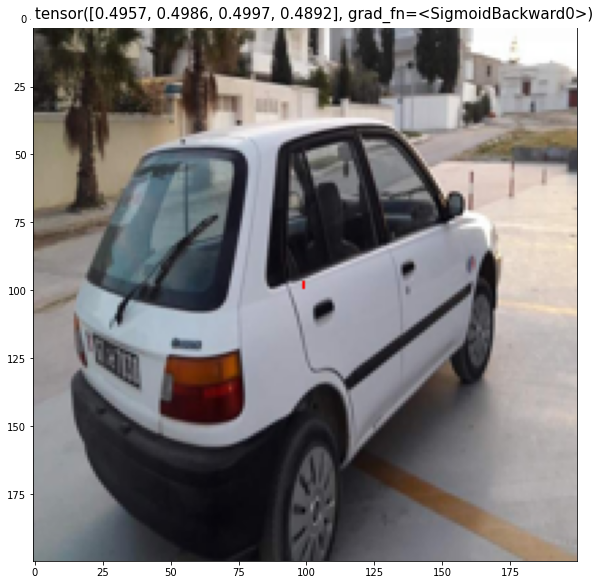

In [115]:
torch.random.manual_seed(10)
dataset = load_transformed_dataset()
print_dataset_entry((dataset[0][0], Model()(dataset[0][0])))

In [116]:
def split_dataset(dataset : Dataset, ratio):
    split_index = int(ratio * len(dataset.data))
    return (Dataset(dataset.data[:split_index], dataset.input_transforms, dataset.target_transforms),
            Dataset(dataset.data[split_index:], dataset.input_transforms, dataset.target_transforms))

In [117]:
def shuffle_dataset(dataset : Dataset, seed = None):
    if seed is not None:
        random.seed(seed)
    random.shuffle(dataset.data)
    return dataset

In [118]:
def load_training_validation_datasets():
    shuffled_dataset = shuffle_dataset(load_transformed_dataset())
    training_dataset, validation_dataset = split_dataset(shuffled_dataset, TRAIN_VALIDATION_SPLIT_RATIO)
    return training_dataset, validation_dataset

In [119]:
def load_training_validation_dataloaders():
    training_dataset, validation_dataset = load_training_validation_datasets()
    # Do not multithread with 'num_workers' -> It doesn't work properly on windows (Pickle error)
    return (
        torch.utils.data.DataLoader(training_dataset, batch_size=TRAIN_BATCH_SIZE, shuffle=True),
        torch.utils.data.DataLoader(validation_dataset, batch_size=TRAIN_BATCH_SIZE),
    )

Total loss: 0.367
Epoch: 0
Total loss: 0.219
Epoch: 1
Total loss: 0.217


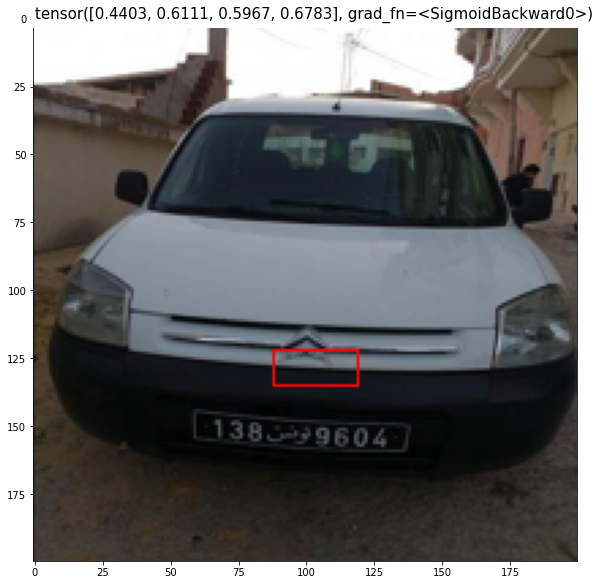

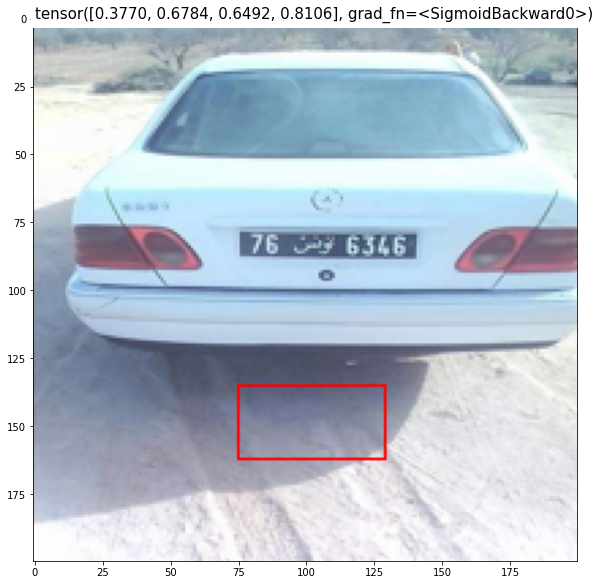

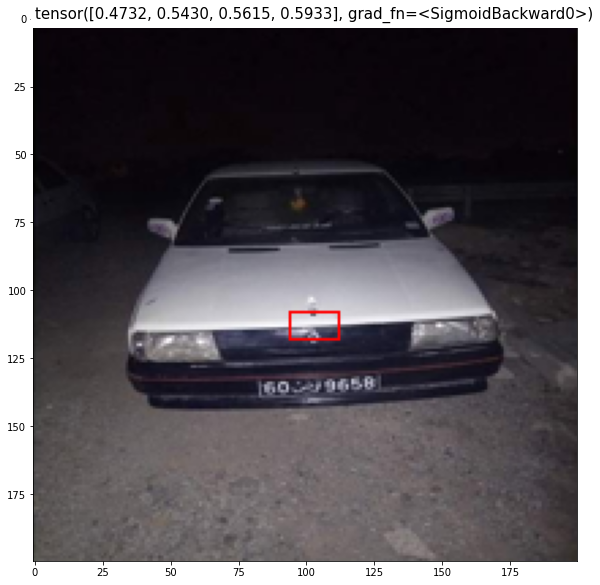

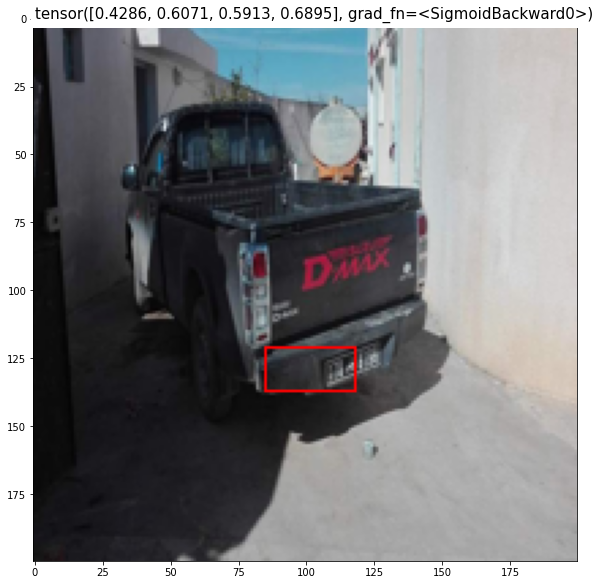

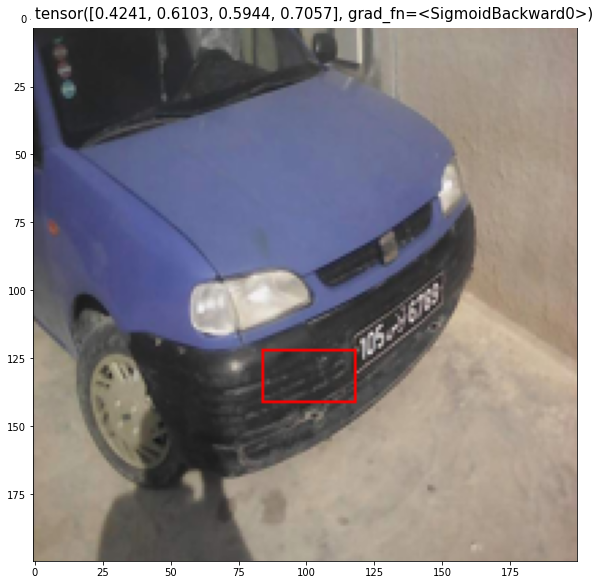

In [120]:
training_dataloader, validation_dataloader = load_training_validation_dataloaders()

model = Model()
criterion = torch.nn.MSELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01)

if torch.cuda.is_available():
    model = model.cuda()

def train(num_epochs, dataloader, model, criterion, optimizer):
    for epoch in range(num_epochs):
        for index, (inputs, targets) in enumerate(dataloader):          
            for batch_index in range(len(inputs)):
                input, target = inputs[batch_index], targets[batch_index]
            
                output = model(input)
                loss = criterion(output, target)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()


def validate(dataloader, model, criterion):
    total_loss = 0
    with torch.no_grad():
        for _, (inputs, targets) in enumerate(dataloader):
            for batch_index in range(len(inputs)):
                input, target = inputs[batch_index], targets[batch_index]
            
                output = model(input)
                loss = criterion(output, target)
                total_loss += loss.item()

    print(f"Total loss: {total_loss:.3f}")

validate(validation_dataloader, model, criterion)
for epoch in range(2):
    print(f"Epoch: {epoch}")
    train(1, training_dataloader, model, criterion, optimizer)
    validate(validation_dataloader, model, criterion)

for validation_dataset_entry in list(validation_dataloader.dataset)[:5]:
    print_dataset_entry((validation_dataset_entry[0], model(validation_dataset_entry[0])))